# Working with Superphot+

Superphot+ was designed to rapidly fit photometric SN-like light curves to an empirical model for subsequent classification or analysis.
This tutorial briefly covers how to import light curves directly from ALeRCE or ANTARES, apply pre-processing for improved quality, and run various sampling methods to fit the light curves.

## Data Importing and Preprocessing

Superphot+ is built on SNAPI (https://github.com/kdesoto-astro/snapi), which provides functionality for easy importing and pre-processing of photometric data from various alert brokers. Here, we use SNAPI to import a ZTF light curve from ALeRCE.

In [1]:
# All imports/filepaths for this section
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from snapi.query_agents import ALeRCEQueryAgent, TNSQueryAgent
from snapi import Formatter, Photometry, Transient

test_sn = "2023lkw"
p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")
print(SAVE_DIR)


/Users/kdesoto/python_repos/superphot-plus/data/tutorial


In [2]:
alerce_agent = ALeRCEQueryAgent()
tns_agent = TNSQueryAgent()
transient = Transient(iid=test_sn)
qr_tns, success = tns_agent.query_transient(transient, local=True) # we dont want spectra
for result in qr_tns:
    transient.ingest_query_info(result.to_dict())
print(transient.internal_names)
qr_alerce, success = alerce_agent.query_transient(transient)
for result in qr_alerce:
    transient.ingest_query_info(result.to_dict())

{'Gaia23cpz', 'ATLAS23nab', 'PS23ezy', 'ZTF23aaphnyz'}


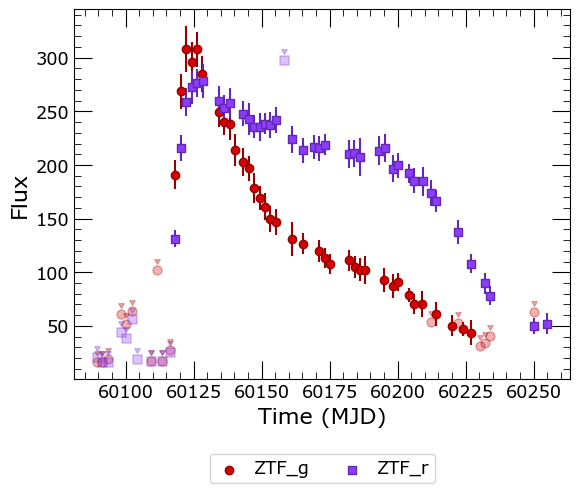

In [3]:
# plot imported LC
photometry = transient.photometry
formatter = Formatter()
fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()

Here, the nondetections are marked as semi-transparent upper-limits, with the detections shown opaque wih uncertainty margins. Superphot+ currently only works with detections.

Let's phase/normalize the light curve and correct for extinction. Note that, for the Superphot+ samplers, the photometry MUST be phased and normalized to be fit correctly.

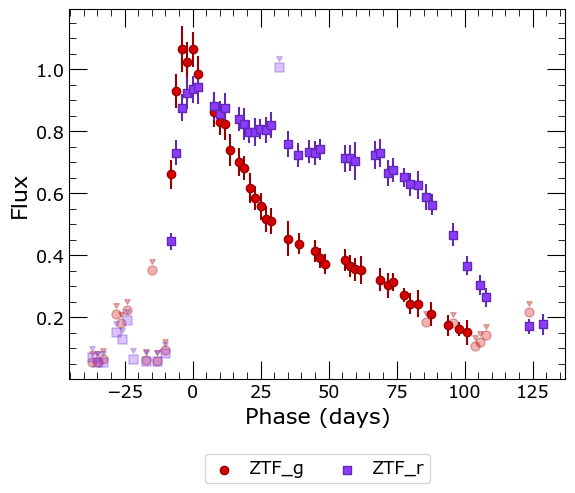

In [4]:
photometry.phase(inplace=True)
photometry.normalize(inplace=True)
photometry.correct_extinction(coordinates=transient.coordinates, inplace=True)
transient.photometry = photometry

fig, ax = plt.subplots()

photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


Now let's save this file for later use:

In [5]:
transient.save(
    os.path.join(SAVE_DIR, test_sn)
)

For our numpyro samplers, we need to pad all bands to have the same number of points. To do this, we create a padded variant of our transient photometry:

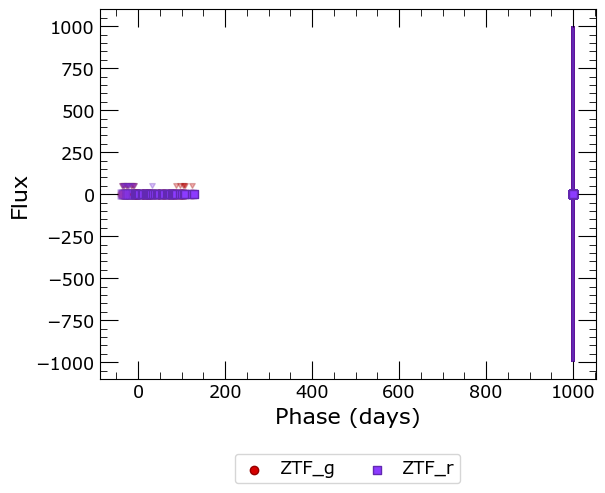

In [6]:
transient = Transient.load(
    os.path.join(SAVE_DIR, test_sn),
)

n_pad = int(2**np.ceil(np.log2(len(transient.photometry.detections))))

padded_lcs = set()
fill = {'phase': 1000., 'flux': 0.1, 'flux_unc': 1000., 'zpt': 23.90, 'non_detections': False}

padded_lcs = []
for lc in transient.photometry.light_curves:
    padded_lc=lc.pad(fill, n_pad - len(lc.detections))
    padded_lcs.append(padded_lc)

padded_photometry = Photometry.from_light_curves(padded_lcs)
transient.photometry = padded_photometry
transient.save(
    os.path.join(SAVE_DIR, test_sn+"_padded")
)
formatter = Formatter()
fig, ax = plt.subplots()
padded_photometry.plot(ax, mags=False)
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


## Fitting Light Curves

In [2]:
# All imports for this section
import os
from pathlib import Path

import matplotlib.pyplot as plt
from snapi import Transient, Formatter, SamplerResult

from superphot_plus.samplers import DynestySampler, NUTSSampler, SVISampler
from superphot_plus.priors import generate_priors

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")

test_sn = "2023lkw"

There are a few sampling techniques implemented for rapid fitting of light curves:
* Nested sampling (`dynesty`) constrains the posterior space with nested ellipsoids of increasing density.
* Advanced HMC with the NUTS sampler (using `numpyro`) uses Hamiltonian Monte Carlo sampling but without U-turns to increase sampling efficiency.
* Stochastic variational inference (SVI; also using `numpyro`) approximates the marginal distributions for each fit as Gaussians, which sacrifices precision for much faster runtime. Recommended for realtime applications.

Let's use each to fit our test light curve:

In [3]:
fn_to_fit = os.path.join(SAVE_DIR, test_sn)
transient = Transient.load(fn_to_fit)
photometry = transient.photometry
priors = generate_priors(["ZTF_r","ZTF_g"])

2025-01-09 14:55:55,538 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-01-09 14:55:55,542 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


In [4]:
%%time

sampler = DynestySampler(
    priors=priors,
    random_state=42,
    verbose=True,
)
sampler.fit_photometry(photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}")
)
print("Nested sampling")
print(sampler.result.fit_parameters.head())

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(
2190it [00:16, 135.62it/s, +50 | bound: 255 | nc: 1 | ncall: 70803 | eff(%):  3.166 | loglstar:   -inf < 146.507 <    inf | logz: 103.819 +/-    nan | dlogz:  0.008 >  0.400]


Nested sampling
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  0.947698    0.004022    94.992724  -7.672709        1.041031   
1  0.952499    0.003919    95.342300  -7.935776        1.040247   
2  0.919933    0.003722    94.604460  -7.768824        1.010149   
3  0.938055    0.003748    90.999194  -7.658021        1.218893   
4  0.925128    0.003558    93.786318  -8.032293        1.233964   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       30.795662           0.007849  1.086854    0.013105    18.303826   
1       29.682900           0.007847  0.969147   -0.000252     8.100830   
2       30.022968           0.004280  1.035752   -0.000235     6.700997   
3       33.164173           0.013095  1.025781    0.007972    11.432417   
4       29.286025           0.010788  0.972020    0.002886     8.780183   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -8.233200        0.696400       54.011553           0.024217 

In [5]:
%%time

# use padded photometry
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = NUTSSampler(
    priors=priors,
    num_chains=1,
    num_warmup=5000,
    num_samples=1000,
    random_state=42
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}")
)
print("NUTS")
print(sampler.result.fit_parameters.head())

sample: 100%|██████████| 6000/6000 [00:44<00:00, 135.95it/s, 31 steps of size 8.49e-02. acc. prob=0.92]  


NUTS
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  0.912766    0.003516    91.224480  -8.064760        1.121789   
1  0.925343    0.003460    91.545456  -8.093802        1.110540   
2  0.952839    0.004124    95.111778  -7.735003        1.037410   
3  0.974721    0.004318    94.239204  -7.934460        1.407066   
4  0.957989    0.004072    94.044701  -7.845119        1.901500   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       34.007603           0.012897  1.730190    0.008002    14.651421   
1       32.345512           0.004787  1.683562    0.007549     5.583376   
2       31.382544           0.001743  1.802787    0.012669    15.642739   
3       33.423809           0.002073  1.941398   -0.002238     1.082958   
4       31.246897           0.005303  1.751868    0.002058     8.789068   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -7.890611       25.709312       31.072824           0.113129  
1 -10.131

In [6]:
%%time

# use padded photometry: only necessary if you're planning on running repeatedly on different events
# if one-time fit, feel free to not use padding
padded_fn = os.path.join(SAVE_DIR, test_sn + "_padded")
pad_transient = Transient.load(padded_fn)
pad_photometry = pad_transient.photometry

sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=42,
)
sampler.fit_photometry(pad_photometry)
sampler.result.save(
    os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}")
)
print("SVI")
print(sampler.result.fit_parameters.head())

SVI
    A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0  0.931900    0.003683    93.618828  -7.945735        1.522983   
1  0.911019    0.003341    88.481346  -8.679517        1.119761   
2  0.918408    0.003463    90.279434  -8.417963        1.249499   
3  0.932533    0.003694    93.777252  -7.923751        1.537082   
4  0.932008    0.003685    93.645889  -7.941976        1.525385   

   tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
0       31.754049           0.020047  1.109669    0.011560    30.940275   
1       26.405420           0.012605  1.059455    0.010054    26.655552   
2       28.199835           0.014872  1.077088    0.010591    28.110126   
3       31.930008           0.020327  1.111210    0.011605    31.078762   
4       31.784063           0.020095  1.109933    0.011568    30.963911   

   t_0_ZTF_g  tau_rise_ZTF_g  tau_fall_ZTF_g  extra_sigma_ZTF_g  
0  -8.426150        1.339716       31.358217           0.043616  
1  -9.1307

Now, let's plot each fit to compare results!

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


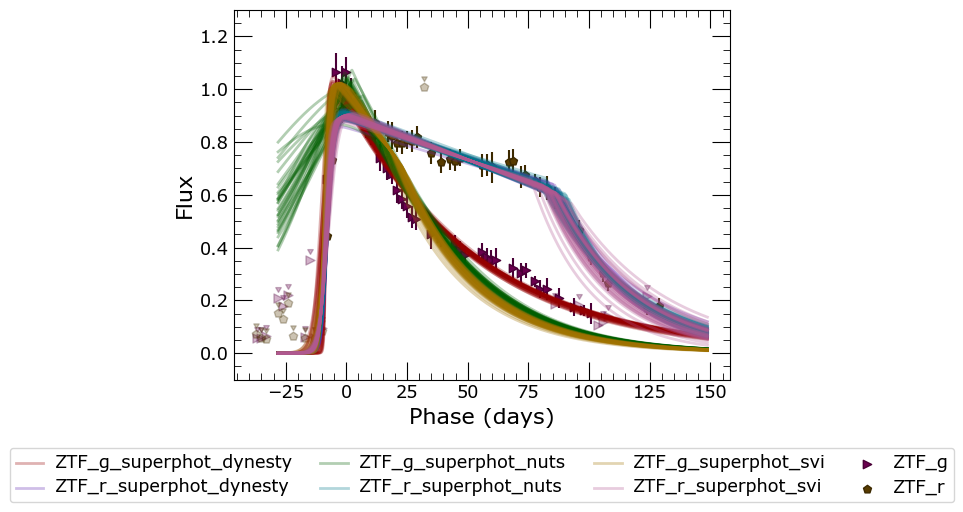

In [7]:
fn_to_fit = os.path.join(SAVE_DIR, test_sn)
transient = Transient.load(fn_to_fit)
photometry = transient.photometry
priors = generate_priors(["ZTF_r","ZTF_g"])

fig, ax = plt.subplots()
formatter = Formatter()
dsampler = DynestySampler(priors=priors)
nsampler = NUTSSampler(priors=priors)
ssampler = SVISampler(priors=priors)
for sampler in [dsampler, nsampler, ssampler]:
    sr = SamplerResult.load(os.path.join(SAVE_DIR, test_sn+f"_{sampler.name}"))
    sampler.load_result(sr)
    ax = sampler.plot_fit(
        ax, formatter,
        photometry,
    )
photometry.plot(ax, formatter, mags=False)
ax.set_ylim((-0.1, 1.3))
formatter.add_legend(ax)
formatter.make_plot_pretty(ax)
plt.show()


All three fits look decent, though dynesty seems to capture the g-band secondary bump a bit better. Let's access and compare that g-band tau_fall value:

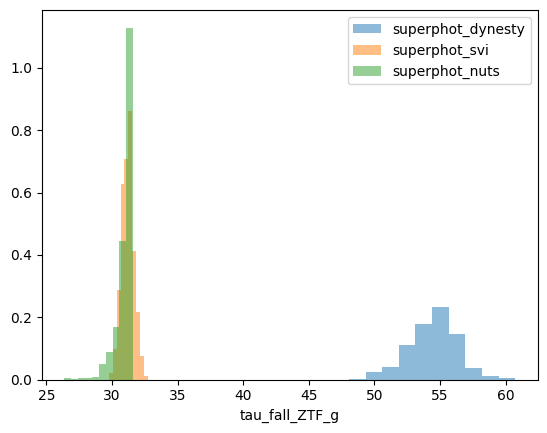

In [8]:
for sampler_name in ["superphot_dynesty", "superphot_svi", "superphot_nuts"]:
    sr = SamplerResult.load(os.path.join(SAVE_DIR, test_sn+f"_{sampler_name}"))
    fit_params = sr.fit_parameters
    # param naming convention: {paramname}_{filter}
    plt.hist(fit_params["tau_fall_ZTF_g"], alpha=0.5, label=sampler_name, density=True)

plt.xlabel("tau_fall_ZTF_g")
plt.legend()
plt.show()

## Classification

Superphot+ uses the resulting fit parameters as input features for a LightGBM classifier. We can call the model's evaluate() function to return probabilities of the object being each of 5 major supernova types. But first, we convert our auxiliary-band and log-Gaussian parameters back to Gaussian relative values, for better normalization before classification.

In [9]:
import os
import numpy as np
from superphot_plus.priors import generate_priors
from superphot_plus.supernova_class import SupernovaClass
from superphot_plus.model import SuperphotLightGBM
from snapi import SamplerResult
from pathlib import Path

p = Path(os.getcwd()).parents[1]
SAVE_DIR = os.path.join(p, "data", "tutorial")
test_sn = "2023lkw"


In [10]:

model_fn = os.path.join(SAVE_DIR, "model_superphot_full.pt")
full_model = SuperphotLightGBM.load(model_fn)
priors = generate_priors(["ZTF_r","ZTF_g"])
sr = SamplerResult.load(os.path.join(SAVE_DIR, test_sn+f"_superphot_dynesty"))

# convert fit parameters back to uncorrelated Gaussian draws
uncorr_fits = priors.reverse_transform(sr.fit_parameters)

# fix index for groupby() operations within model.evaluate()
uncorr_fits.index = [test_sn,] * len(uncorr_fits)

# use full-phase classifier
probs_avg = full_model.evaluate(uncorr_fits)
probs_avg.columns = np.sort(SupernovaClass.all_classes())

# get predicted SN class and output probability of that classification
pred_class = probs_avg.idxmax(axis=1).iloc[0]
print(probs_avg, pred_class)

           SLSN-I     SN II    SN IIn     SN Ia    SN Ibc
2023lkw  0.021705  0.898169  0.029526  0.041202  0.009398 SN II


Looking at the TNS page, we see that 2023lkw is indeed a SN II.